# Estimating Parking Cost and Spatial Autocorrelation Analysis of Parking Data

Goals:
   1. Join csv cost data with spatial data for parking lots
   2. Make maps to show data
   3. Estimate Ratios of M to D, D to H, M to H to estimate missing rates values.
   4. Global and Local Spatial Autocorrelation (Moran's I and Getis-Ord Gi*)
       - If Local Spatial Autocorrelation found - attempt interpolation methodologies:
           - IDW for points to polygons (TAZs)
           - KNN for points to polygons (TAZs)

For inflation adjustment: https://www.inflationtool.com/us-dollar/2010-to-present-value    

Sources:
- https://notebook.community/ocefpaf/folium/examples/Colormaps
- https://nbviewer.org/github/FloChehab/folium/blob/fix_choropleth/examples/GeoJSON_and_choropleth.ipynb
- https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html
- https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html
- https://gdal.org/programs/gdal_grid.html#interpolation-algorithms
- https://github.com/pysal/esda/tree/master/esda
- https://geographicdata.science/book/notebooks/04_spatial_weights.html

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import pysal
from osgeo import gdal
import folium # interactive mapping
import branca.colormap as cm # for interactive mapping
import osmnx as ox
import networkx as nx
import copy
import libpysal as lps
from libpysal import weights
from esda.moran import Moran #spatial autocorrelation
from esda.moran import Moran_Local
import scipy
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
import keplergl
from libpysal.weights.util import WSP

## Bring In Data

1. Lot Rates
2. Lot Points
3. Join Points and Rates
4. Filter Lots (must have at least one rate)
5. TAZs

In [ ]:
# bring in data
base = "J:\\Shared drives\\TMD_TSA\\Data\\Parking\\WebScraped_ParkingCost\\required_inputs"
# parking costs
rates = pd.read_csv(base+"\parking_cost_fullrec_NAP_F16.csv")

# spatial points
points = gpd.read_file(base+"\GeocodedParkingLots\DKedits_parking_cost_fullrec_NAP.shp")
points = points.dropna(subset=["geometry"])

# join cost to points
lots = points[['IN_SingleL','geometry','USER_month','USER_lot_u']].merge(rates[['IN_SingleLine','USER_lot_url',
                                                                                'MR','DR','HR']],
                                                                         left_on='USER_lot_u',right_on='USER_lot_url')
# drop lots of columns
# reproject for easier mapping (From mass state plane to wgs84)
lots = lots.to_crs("EPSG:4326")

# filter out customer only parking (no rates for any category)
lots = lots[(~lots['MR'].isna()) | (~lots['DR'].isna()) | (~lots['HR'].isna())]

In [ ]:
# bring in relevant TAZs
base2 = "J:\Shared drives\TMD_TSA\Data\GIS Data\TAZ"
alltazs = gpd.read_file(base2+"\\candidate_CTPS_TAZ_STATEWIDE_2019_wgs84.shp")
# filter to just relevant municipalities
districts = alltazs[(alltazs['town'].isin(["BOSTON","CAMBRIDGE","SOMERVILLE","BROOKLINE","NEWTON"])) & (alltazs['id'] < 200000)][["id","town","geometry"]]

In [ ]:
districts

## Estimate and Fill Missing Monthly Rates

Calculate the Monthly/Daily ratio per district by dividing the monthly column by the daily column to get lot level ratios and aggregate to the region. This region-wide ratio is multiplied by each lot's Daily Rate to calculate an estimated monthly rate. At this point, a new column is made where observed monthly rate data unless missing, then estimated monthly rate data is used if existing (aka if lot has a daily rate). 

This will be conducted for M/D, D/H, and M/H - M/D is used as the example for the explanation for ease of understanding.

In [ ]:
# spatial join - for every lot get district
lotdist = lots.sjoin(districts.reset_index(), how="left")

### Monthly to Daily

In [ ]:
#copy from prior section
estmonth = copy.copy(lotdist)
#get ratio at the lot level
estmonth['Monthly_to_Daily'] = estmonth['MR']/estmonth['DR']
estmonth[estmonth['Monthly_to_Daily'] > 0]

In [ ]:
# Get the mean ratio for the region
estmonth['Monthly_to_Daily'].mean()

In [ ]:
# estimate monthly from daily and mean regional ratio (using only where both values)
estmonth['Est_Monthly'] = estmonth['DR'] * estmonth['Monthly_to_Daily'].mean()

# combine estimated daily with actual daily where possible
estmonth['Monthly_Rate_wEst'] = np.where(estmonth['MR'].isna(),
                                         estmonth['Est_Monthly'],
                                         estmonth['MR'])

### Daily to Hourly

In [ ]:
#get D to H ratio at the lot level
# if divide by 0, just set to 0
estmonth['Daily_to_Hourly'] = np.where(estmonth['HR'] == 0,None,estmonth['DR']/estmonth['HR'])
estmonth[estmonth['Daily_to_Hourly'] > 0]

In [ ]:
# calculate regional mean of D to H ratio
estmonth['Daily_to_Hourly'].mean()

In [ ]:
# estimate Daily from Hourly and mean regional ratio (using only where both values)
estmonth['Est_Daily'] = estmonth['HR'] * estmonth['Daily_to_Hourly'].mean()

# combine estimated daily with actual daily where possible
estmonth['Daily_Rate_wEst'] = np.where(estmonth['DR'].isna(),
                                         estmonth['Est_Daily'],
                                         estmonth['DR'])

### Monthly to Hourly 
(Derived from Daily to Hourly Ratio and Monthly to Daily Ratio)

In [ ]:
#get Monthly to Hourly ratio at the lot level
# if divide by 0, just set to 0
estmonth['Monthly_to_Hourly'] = estmonth['Daily_to_Hourly']*estmonth['Monthly_to_Daily']
estmonth[~estmonth['Monthly_to_Hourly'].isna()]

In [ ]:
# calculate regional mean of monthly to hourly ratio 
estmonth['Monthly_to_Hourly'].mean()

In [ ]:
# estimate Hourly from Monthly and mean regional ratio (using only where both values)
estmonth['Est_Hourly'] = estmonth['MR'] / estmonth['Monthly_to_Hourly'].mean()

# combine estimated daily with actual daily where possible
estmonth['Hourly_Rate_wEst'] = np.where(estmonth['HR'].isna(),
                                         estmonth['Est_Hourly'],
                                         estmonth['HR'])


### Round 2 of Estimation of Missing Parking Lot Rates

In [ ]:
# estimate monthly from daily and mean regional ratio (using only where both values)
estmonth['Est_Monthly2'] = estmonth['Daily_Rate_wEst'] * estmonth['Monthly_to_Daily'].mean()

# combine estimated daily with actual daily where possible
estmonth['Monthly_Rate_wEst2'] = np.where(estmonth['Monthly_Rate_wEst'].isna(),
                                         estmonth['Est_Monthly2'],
                                         estmonth['Monthly_Rate_wEst'])

# estimate Daily from Hourly and mean regional ratio (using only where both values)
estmonth['Est_Daily2'] = estmonth['Hourly_Rate_wEst'] * estmonth['Daily_to_Hourly'].mean()

# combine estimated daily with actual daily where possible
estmonth['Daily_Rate_wEst2'] = np.where(estmonth['Daily_Rate_wEst'].isna(),
                                         estmonth['Est_Daily2'],
                                         estmonth['Daily_Rate_wEst'])

# estimate Hourly from Monthly and mean regional ratio (using only where both values)
estmonth['Est_Hourly2'] = estmonth['Monthly_Rate_wEst'] / estmonth['Monthly_to_Hourly'].mean()

# combine estimated daily with actual daily where possible
estmonth['Hourly_Rate_wEst2'] = np.where(estmonth['Hourly_Rate_wEst'].isna(),
                                         estmonth['Est_Hourly2'],
                                         estmonth['Hourly_Rate_wEst'])


In [ ]:
estmonth

In [ ]:
estmonth.loc[estmonth['Hourly_Rate_wEst'] != estmonth['Hourly_Rate_wEst2']][["Hourly_Rate_wEst", "Hourly_Rate_wEst2", "Monthly_Rate_wEst"]]

In [ ]:
estmonth.to_csv("J:\Shared drives\TMD_TSA\Data\Parking\WebScraped_ParkingCost\estmonth.csv")

### SUMMARY STATISTICS FOR RATIO CALCULATIONS

In [ ]:
# SUMMARY STATS
#none of these stats include NAs
sumdict = {}
sumdict['Monthly_to_Hourly'] = {'Avg': estmonth['Monthly_to_Hourly'].mean(),'Min': estmonth['Monthly_to_Hourly'].min(),
                               'Max': estmonth['Monthly_to_Hourly'].max(),'std':estmonth['Monthly_to_Hourly'].std(),
                               'Count' : estmonth['Monthly_to_Hourly'].count()}
sumdict['Daily_to_Hourly'] = {'Avg': estmonth['Daily_to_Hourly'].mean(),'Min': estmonth['Daily_to_Hourly'].min(),
                               'Max': estmonth['Daily_to_Hourly'].max(),'std':estmonth['Daily_to_Hourly'].std(),
                               'Count': estmonth['Daily_to_Hourly'].count()}
sumdict['Monthly_to_Daily'] = {'Avg': estmonth['Monthly_to_Daily'].mean(),'Min': estmonth['Monthly_to_Daily'].min(),
                               'Max': estmonth['Monthly_to_Daily'].max(),'std':estmonth['Monthly_to_Daily'].std(),
                               'Count': estmonth['Monthly_to_Daily'].count()}
stats = pd.DataFrame(sumdict)
stats.head()

In [ ]:
stats.transpose()[['Avg','Min','Max','std']].plot.bar()

## SPATIAL AUTOCORRELATION

1. Moran's I
2. Getis-Ord Gi* (Hot Spot)

- doing global (1) and local (2) spatial autocorrelation (clustering) algorithms for all daily, hourly, monthly, and monthly with estimates rates.


- #### Why am I doing this? 
(https://gisgeography.com/spatial-autocorrelation-moran-i-gis/)
    - TL;DR: Tobler's First Law of Geography ("Everything is related to everything else. But near things are more related than distant things.")
    - "Spatial autocorrelation in GIS helps understand the degree to which one object is similar to other nearby objects." In simple language,"Spatial autocorrelation measures how close [in value] objects are in comparison with other close [over distance] objects."
        - "Positive spatial autocorrelation is when similar values cluster together in a map.
        - Negative spatial autocorrelation is when dissimilar values cluster together in a map."
    - Its not very useful to look at interpolation methods if there is no spatial autocorrelation. The values of pixels in a surface are most accurately interpolated when a pixel has many close neighbors with measured like values. The accuracy will decline as the points get more spread out in relation to the whole dataset and correlated to that, when "near" values get like alikewith less like values especially given that our measured data is not very verbose.
    - If we have 0 or negative global spatial autocorrelation, we will not move forward with interpolation. We will need to have to go back to the data because this would mean that in the case of 0, that the liklihood that points of like values will cluster together is completely random, and if negative, that points of unlike values are likely to be near each other. These conditions make it challenging to estimate nearby values given the pattern is much less straight forward (or is absent in the case of 0).


- #### Makes sense, so why are we doing two types of testing for spatial autocorrelation?
    - Moran's I is global - so if this comes up negative or 0, it doesn't make sense to move forward as this is looking at the dataset as a whole. Moran's I doesn't return an additional information on the point level as it is a global measure. The output is a Z-score and a p-value so the user can assess how far from random (0 standard deviations) the result is. See below: 
    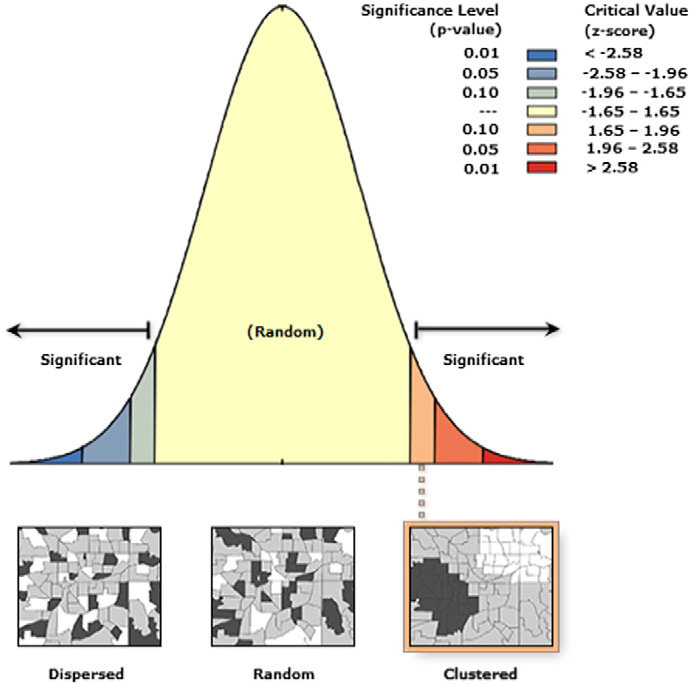
    - However, if Moran's I is positive (meaning we have like values near like values) we know that it is unlikely that this is equally present across the dataset. Some places will have less "neighbors" (near points) and others will have less like values near other like values (possibly an area where if taken alone has 0 or negative or just lower positive spatial autocorrelation?). Additionally, we might want to know where our dataset has clusters of like values in the extremes of our dataset. All of this is addressed by Getis-Ord Gi* which looks at spatial autocorrelation per neighborhood, which is what is meant by "local measure". Points will be labeled with what cluster it is in and whether it is a "hot spot" (high value cluster) or a "cold spot" (low value cluster). This can then be visualized on a map. How hot and cold spots are denoted is by how many standard deviations from the mean the spatial autocorrelation is from random per cluster. 
    
    
#### Moran's I
There are two parts to the Moran's I calculation: 
1. weights (distance based spatial weights)
    - how we define how close points are and therefore neighborhoods
2. values & spatial location (geodataframe)
    - where points are and what the important value is - in this case: parking cost

### Part 1 - Spatial Weights

We are defining how close points are by routing between them (making a skim) instead of using Euclidean Distance. While the impact is likely not huge, the boundary of water features is not included when using Euclidean distance and there are a lot of water features in and around Boston.

    a. Create Graph
    b. Find nearest node on the graph to each lot
    c. Store the relationship between nodes to lots (order is maintained)

In [ ]:
# Create Node/Lot Relationship Table
count = 0
allpoly = districts.dissolve().explode()
for i, row in allpoly.iterrows():
    try:
        net = ox.graph_from_polygon(row['geometry'], network_type='drive')
        if count > 0:
            full_net = nx.compose(full_net, net)
        else:
            full_net = net
        count+=1
    except:
        print(row)
#show graph
ox.plot_graph(full_net)

# reproject lots to match graph (see below)
lots84=estmonth.to_crs('EPSG: 4326')

#project graph to a GCRS as nearest_nodes uses greatest circle for distance and flat planes will give erroneous
full_net84 = ox.project_graph(full_net,to_crs={'proj':'longlat','epsg':'4326'})

# find nearest nodes to parking lots
lot_nodes = ox.nearest_nodes(full_net84, lots84.geometry.x, lots84.geometry.y)

# Create reference dict then table
estmonth['nearest_node'] = lot_nodes

### Create or Import Distance Matrix (skim) and CLean

In [ ]:
# Create or Import Distance Matrix (skim)
'''
# USE ONLY IF YOU NEED A NEW DISTANCE MATRIX THIS CAN TAKE A WHILE TO RUN
# Create graph from OSM

# create origin and destination lists (pairs)
blarg = pd.DataFrame(data=None, index=lot_nodes, columns = lot_nodes)

# Create Skim - this takes about 10 hours to run.
for i in blarg.index:
    j = [i]*len(blarg.columns)
    routes = ox.shortest_path(full_net84, j, blarg.columns, weight='length')
    
    blarg[i] = routes
    
blarg

blarg.to_csv("J:\Shared drives\TMD_TSA\Data\Parking\WebScraped_ParkingCost\\routesnodes_mar16.csv")

# We think that the create skim section is fixed but unclear - if not giving distance use:
def fred(x):
    if type(x) == type([]):
        y = sum(ox.utils_graph.get_route_edge_attributes(full_net84,x,"length",'length'))
    else:
        y = x
    return y
skim = blarg.applymap(lambda x: fred(x))
skim
skim.to_csv("J:\Shared drives\TMD_TSA\Data\Parking\WebScraped_ParkingCost\\skim_mar16.csv")
'''


skim = pd.read_csv("J:\Shared drives\TMD_TSA\Data\Parking\WebScraped_ParkingCost\\required_inputs\\skim_mar16.csv",index_col= 0 )

In [ ]:
# Deal with duplicated columns/index (handled differently, but should be same)
    # Columns take .1, .2 etc suffix, Indices accept duplicates - we would like no duplicates
    # Thankfully in the skim, order should be the same.
skim = skim.set_index(skim.columns)
# Take the Inverse Distance (puts between 0 and 1) - Classic
skim_weighted = 1/skim
# If denominator was 0 (diags), set value = 0
skim_weighted = skim_weighted.applymap(lambda x: 0 if x > 1 else (0 if pd.isna(x) else x))

skim_weighted.to_csv("J:\Shared drives\TMD_TSA\Data\Parking\WebScraped_ParkingCost\\lotskim_weighted_adjusted.csv")
skim_weighted

### FILTER OUT MISSING DATA

While lots with no parking information were filtered out originally, we have seen above that not all records have all three types of rate data. Moran's I requires that no missing data is input - so for each type of rate we need to filter out NAs and the corresponding paths in the skim.

In [ ]:
# make sure the repeated nodes are differentiated (like in skim) (hopefully same order)
estmonth['cols']=skim_weighted.columns

def filter_skim(rates2):
    #for monthly to start - drop NA lots for Monthly by columns and rows
    b = set(pd.Series(skim_weighted.index.astype(str)).tolist())
    c = set(estmonth[estmonth[rates2].isna()]['cols'].astype(str).tolist())

    # drop all columns and rows that involve parking lots with null Monthly rate estimated values
    skim_filtered = skim_weighted.drop(c&b, axis = 0)
    skim_filtered2 = skim_filtered.drop(c&b, axis = 1)
    
    return skim_filtered2


In [ ]:
# Monthly Filtered Skim
skim_weighted_monthly = filter_skim("Monthly_Rate_wEst2")

# Daily Filtered Skim
skim_weighted_daily = filter_skim("Daily_Rate_wEst2")

# Hourly Filtered Skim
skim_weighted_hourly = filter_skim("Hourly_Rate_wEst2")

skim_weighted_monthly


### Create Spatial Weights Objects (From Skim)

Move through Scipy Sparse Distance Matrix

In [ ]:
def make_sw(filtered_weighted_skim):
    '''Create Spatial Weights from Sparse Distance Matrix'''
    sparse = scipy.sparse.csr_matrix(filtered_weighted_skim)
    w = WSP(sparse)
    weights = w.to_W()
    return weights

In [ ]:
# Monthly Spatial Weights
monthly_weights = make_sw(skim_weighted_monthly)
# Daily Spatial Weights
daily_weights = make_sw(skim_weighted_daily)
# Hourly Spatial Weights
hourly_weights = make_sw(skim_weighted_hourly)

monthly_weights.full() # show inside of weights and what lots are islands!

## Run Moran's I

As a note - Moran's I does not accept infinite or NA (missing) rates - the column containing estimated rates must be filtered/edited to compensate for these conditions. This filtering has already been done to the spatial weights through filtering of the skim. Due to every index/column name set having the same order, the spatial weight will match up with the order of lots in the rates column.

In [ ]:
# Moran's I 
# FYI - Issue with this is that 0 is a real value unlike NA, so need to rid of all NAs (also these points from weights)
# Also - rowsum

# Monthly
mimr = Moran(estmonth['Monthly_Rate_wEst2'].round(0).apply(lambda x: 0 if x > 1000 else x).dropna(),  monthly_weights, transformation='r')
# Daily
midr = Moran(estmonth['Daily_Rate_wEst2'].round(0).apply(lambda x: 0 if x > 1000 else x).dropna(),  daily_weights, transformation='r')
# Hourly
mihr = Moran(estmonth['Hourly_Rate_wEst2'].round(0).apply(lambda x: 0 if x > 1000 else x).dropna(),  hourly_weights, transformation='r')

In [ ]:
# Results Table

mitab = pd.DataFrame({'Monthly': {'p_value': mimr.p_norm, 'Z_Score': mimr.z_norm},
                     'Daily': {'p_value': midr.p_norm, 'Z_Score': midr.z_norm},
                     'Hourly': {'p_value': mihr.p_norm, 'Z_Score': mihr.z_norm}})

mitab

In [ ]:
# Visual Summaries of Moran's I Results
plot_moran(mimr, zstandard=True, figsize=(10,4))
plot_moran(midr, zstandard=True, figsize=(10,4))
plot_moran(mihr, zstandard=True, figsize=(10,4))

## What we know so far:

The data is positively spatially autocorrelated - meaning that there is a less than 1% likelihood that this value and spatial clustering pattern was created randomly and that like values are near other like values, globally.

Since we do have positive spatial autocorrelation globally, we can run a local spatial autocorrelation algorithm. In this case - I am using Getis Ord GI* (pronounced Getis Ord GEE EYE STAR), also called Hot-Spot Analysis to see if there are clusters of points with similar values that are either high or low in terms of the range of values. In this algorithm, clusters of 'medium' e.g. value clusters that are not high or low in a statistically significant way. Getis Ord Gi* is (from my experience) the most common local spatial autocorrelation algorithm, but there are more local algorithms that are used than global as Moran's I is a default.

See the following explanation of Getis Ord Gi* from Esri - https://pro.arcgis.com/en/pro-app/2.8/tool-reference/spatial-statistics/h-how-hot-spot-analysis-getis-ord-gi-spatial-stati.htm

"The Hot Spot Analysis tool calculates the Getis-Ord Gi* statistic (pronounced G-i-star) for each feature in a dataset. The resultant z-scores and p-values tell you where features with either high or low values cluster spatially. This tool works by looking at each feature within the context of neighboring features. A feature with a high value is interesting but may not be a statistically significant hot spot. To be a statistically significant hot spot, a feature will have a high value and be surrounded by other features with high values as well. The local sum for a feature and its neighbors is compared proportionally to the sum of all features; when the local sum is very different from the expected local sum, and when that difference is too large to be the result of random chance, a statistically significant z-score results. When the FDR correction is applied, statistical significance is adjusted to account for multiple testing and spatial dependency."

In [ ]:
# Export estmonth as geojson for use in ArcPro and QGIS for Local Moran's I and Getis Ord Gi*
estmonth[["IN_SingleL","geometry","USER_month","USER_lot_u","IN_SingleLine","USER_lot_url","id",
         "town","Monthly_to_Daily","Est_Monthly","Monthly_Rate_wEst","Daily_to_Hourly","Est_Daily",
         "Daily_Rate_wEst","Monthly_to_Hourly","Est_Hourly","Hourly_Rate_wEst","Est_Monthly2","Monthly_Rate_wEst2",
         "Est_Daily2","Daily_Rate_wEst2","Est_Hourly2",
         "Hourly_Rate_wEst2"]].to_file("J:\Shared drives\TMD_TSA\Data\Parking\WebScraped_ParkingCost\estmonth_April25_a.geojson")  

## Results of Local Spatial Autocorrelation

Due to a lack of experience with running spatial autocorrelation in python - Getis Ord Gi* was run in QGIS with the following specifications:
1. KNN = 8 (all neighborhoods have 8 neighbors)
3. Row Standardization
5. Run on Rate column with estimates (nulls)

The results show that for all three rate types (hourly, daily, monthly) there is significant local spatial autocorrelation with high clusters downtown and cold clusters (though more spread out) further out. Given this information - we aggregate the lots rates data to TAZs using the 8 nearest neighbors and distances from the TAZ centroid (euclidean) to create a weighted average. The weights are created for each OD pair where the weight is 1/(distance)^2 (squared)

To identify outliers within clusters to smooth the weighted averages assigned to TAZs, Local Moran's I was run with the same specifications as Getis Ord Gi* above. The results are below. Please note that the legends for the maps are the same as for the graphs.


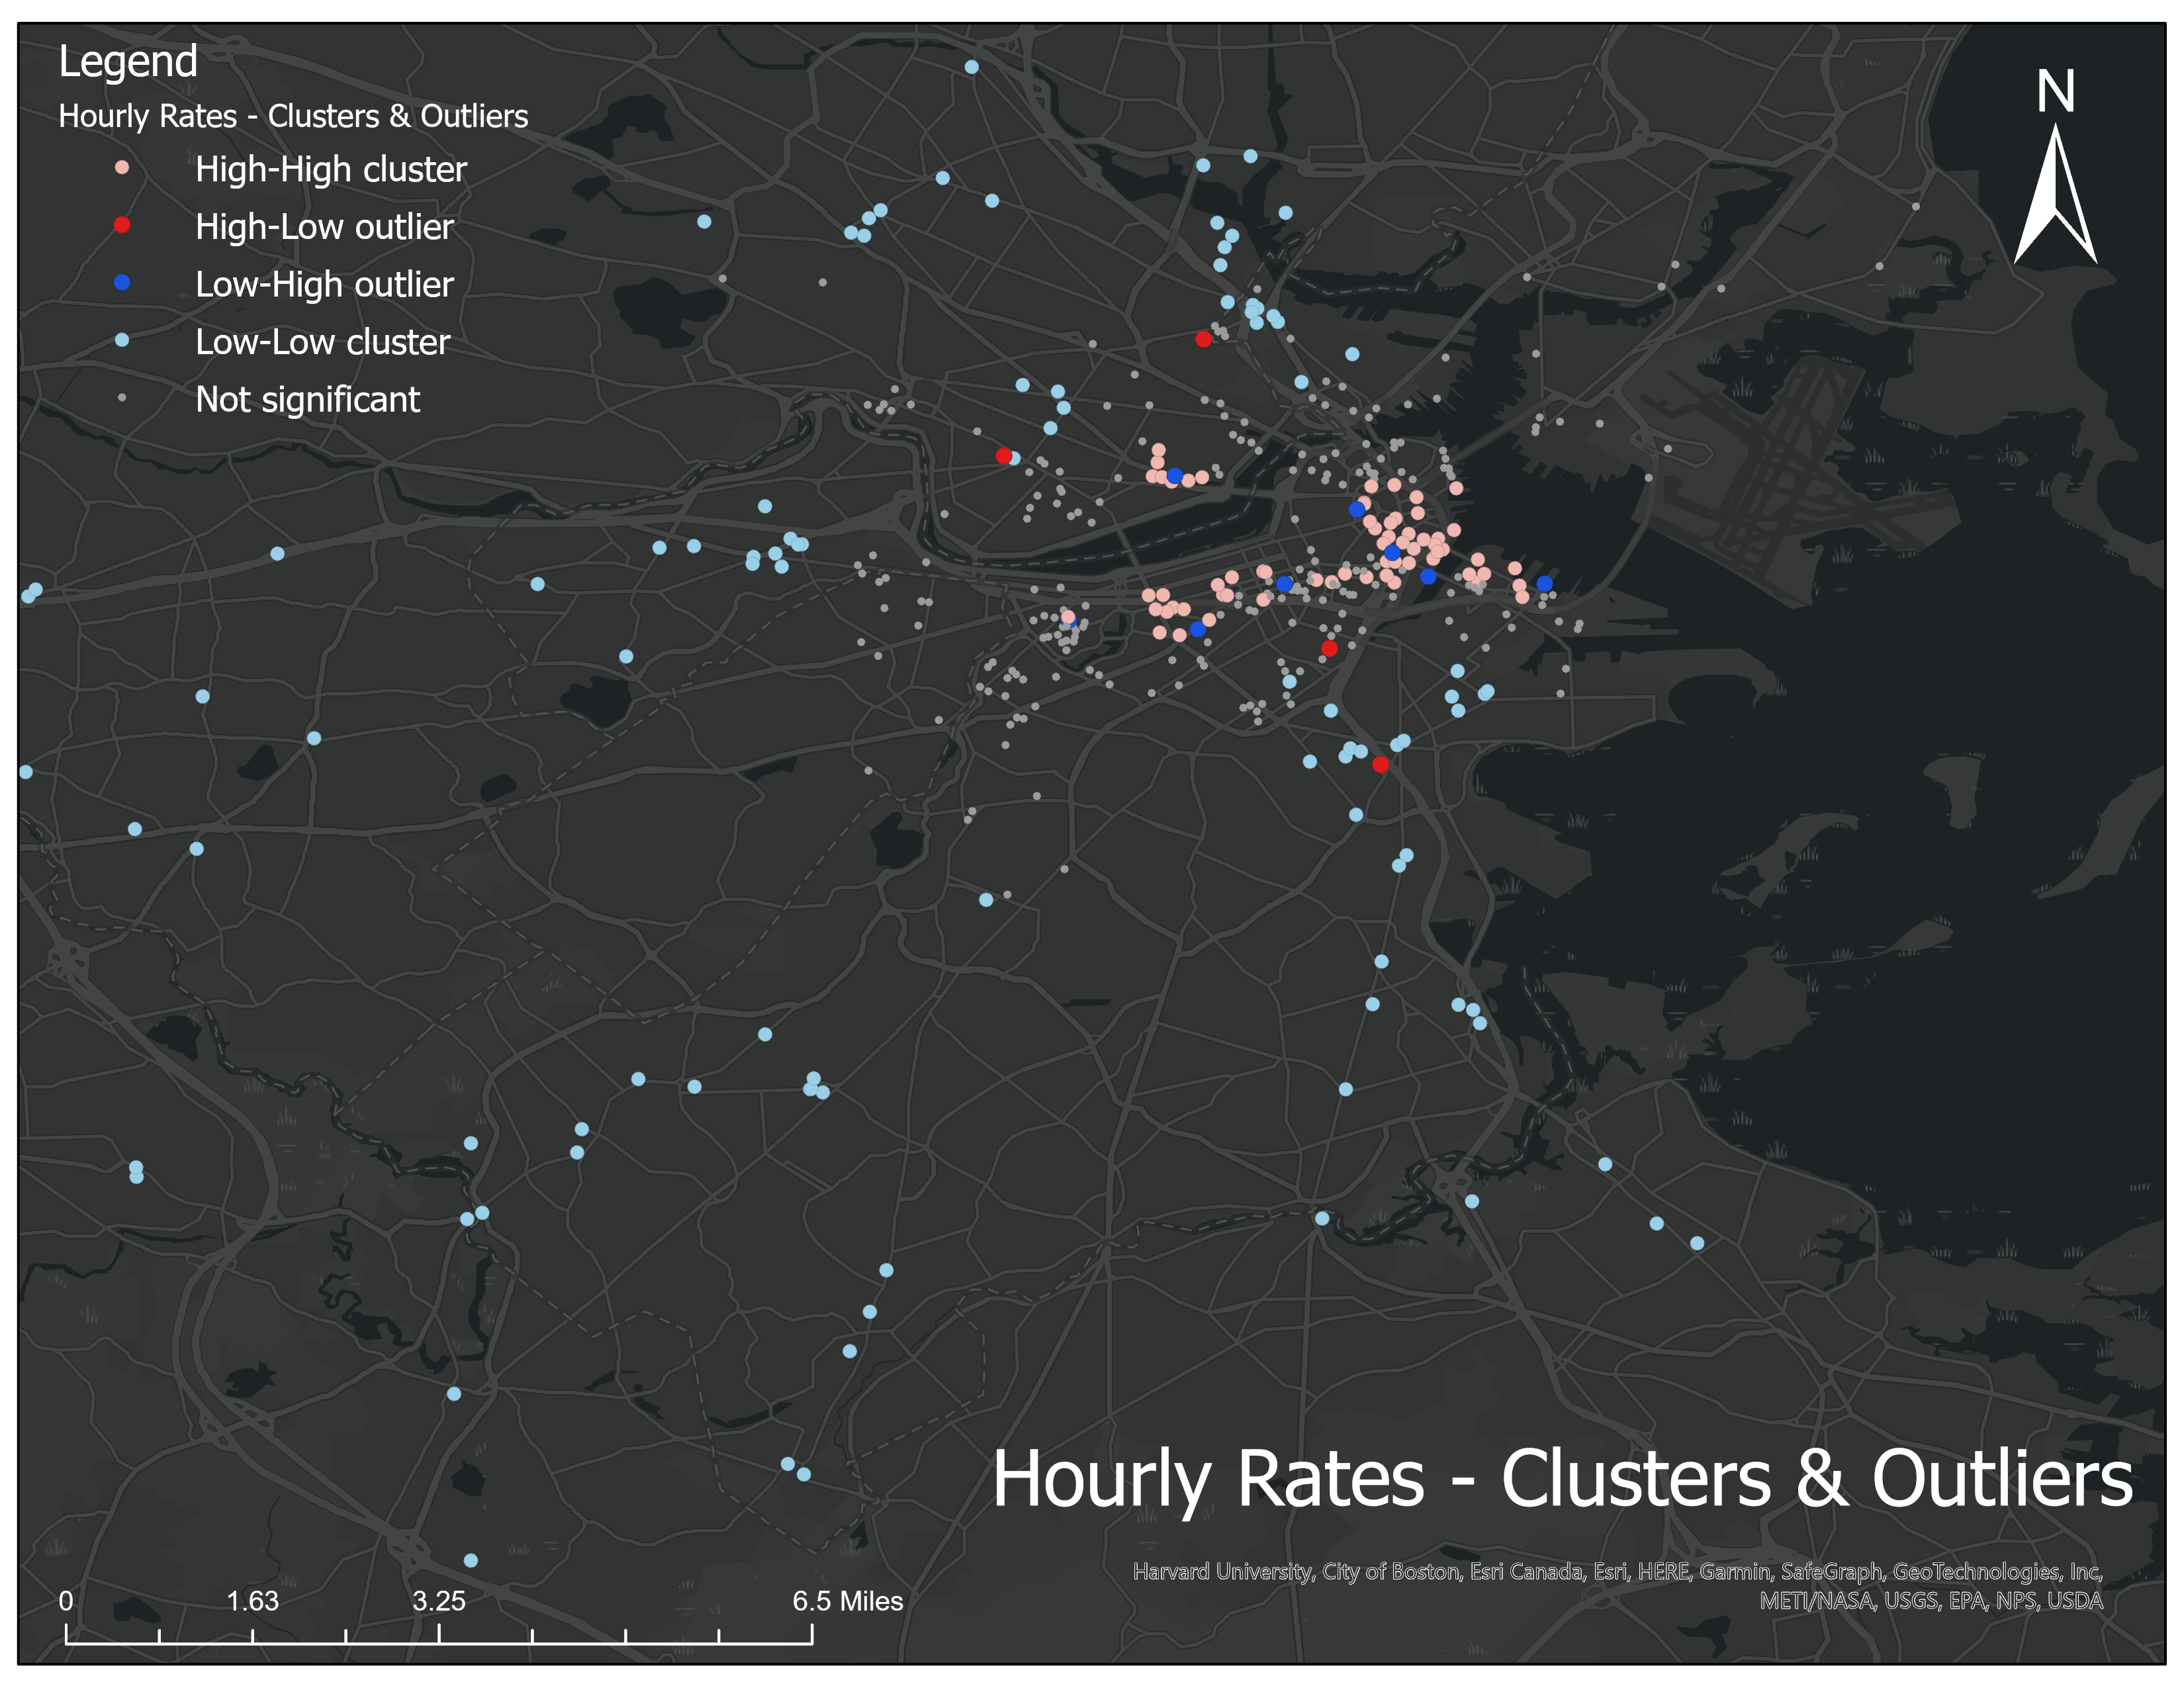

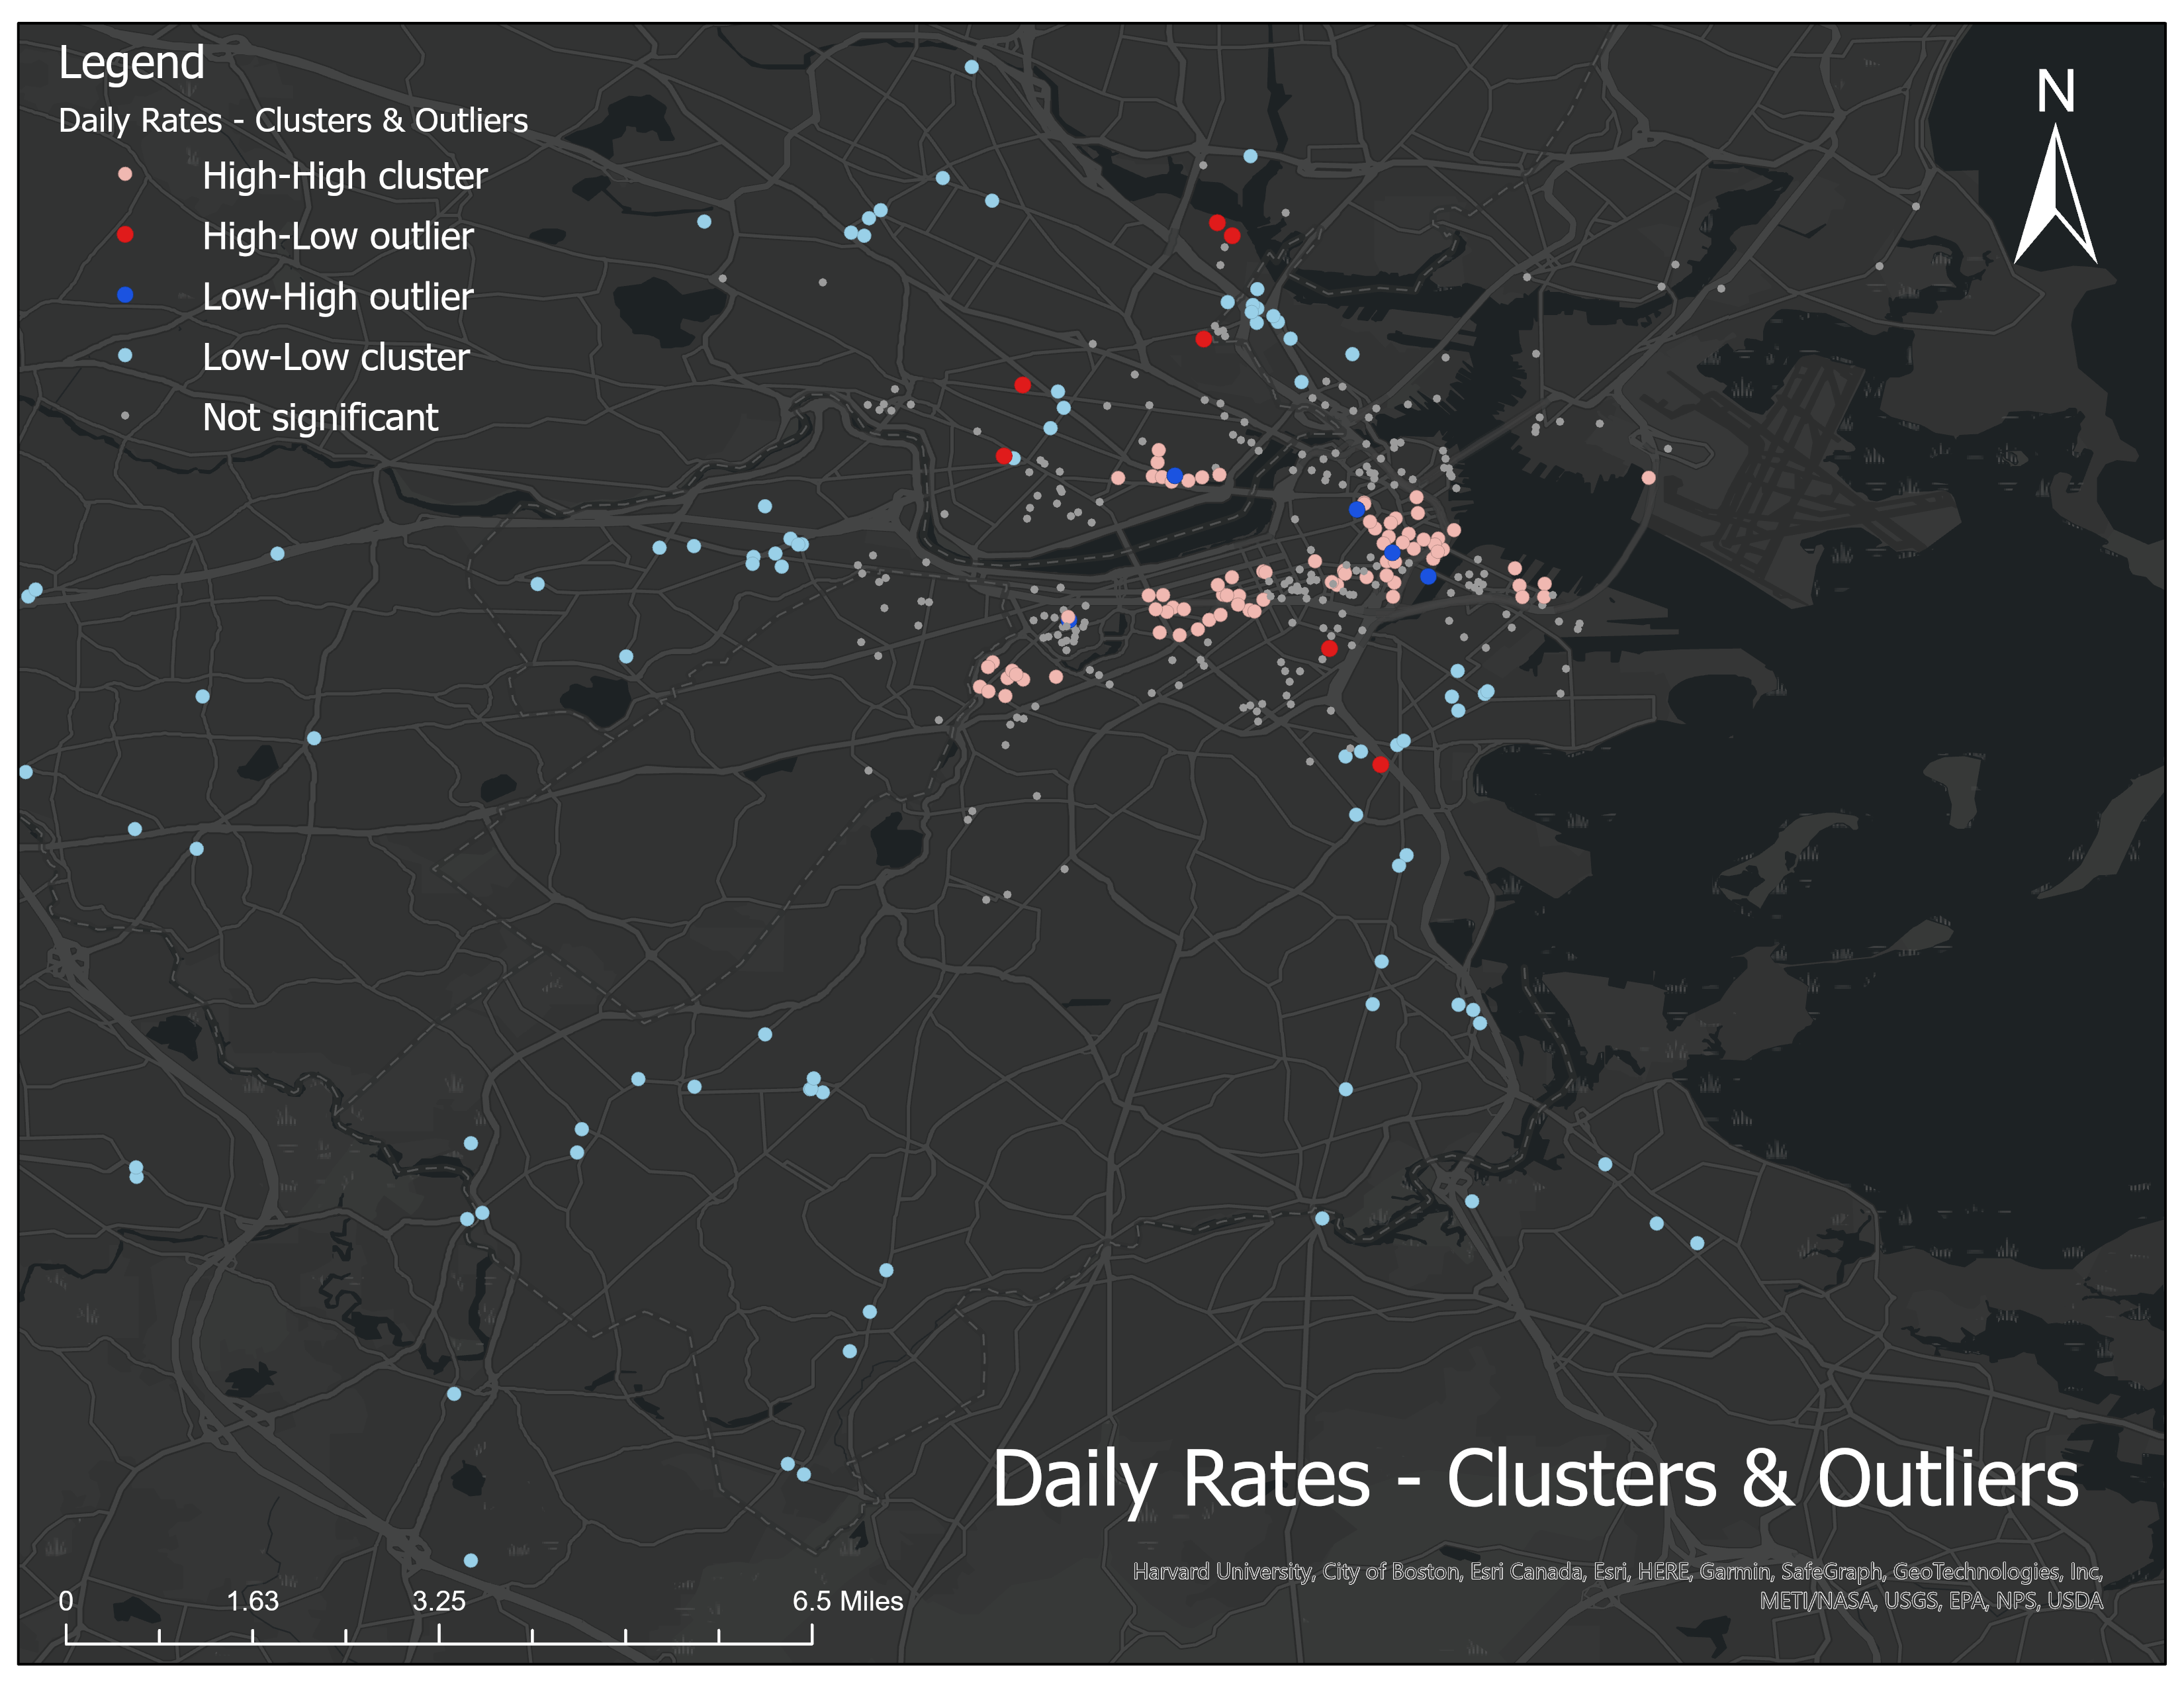

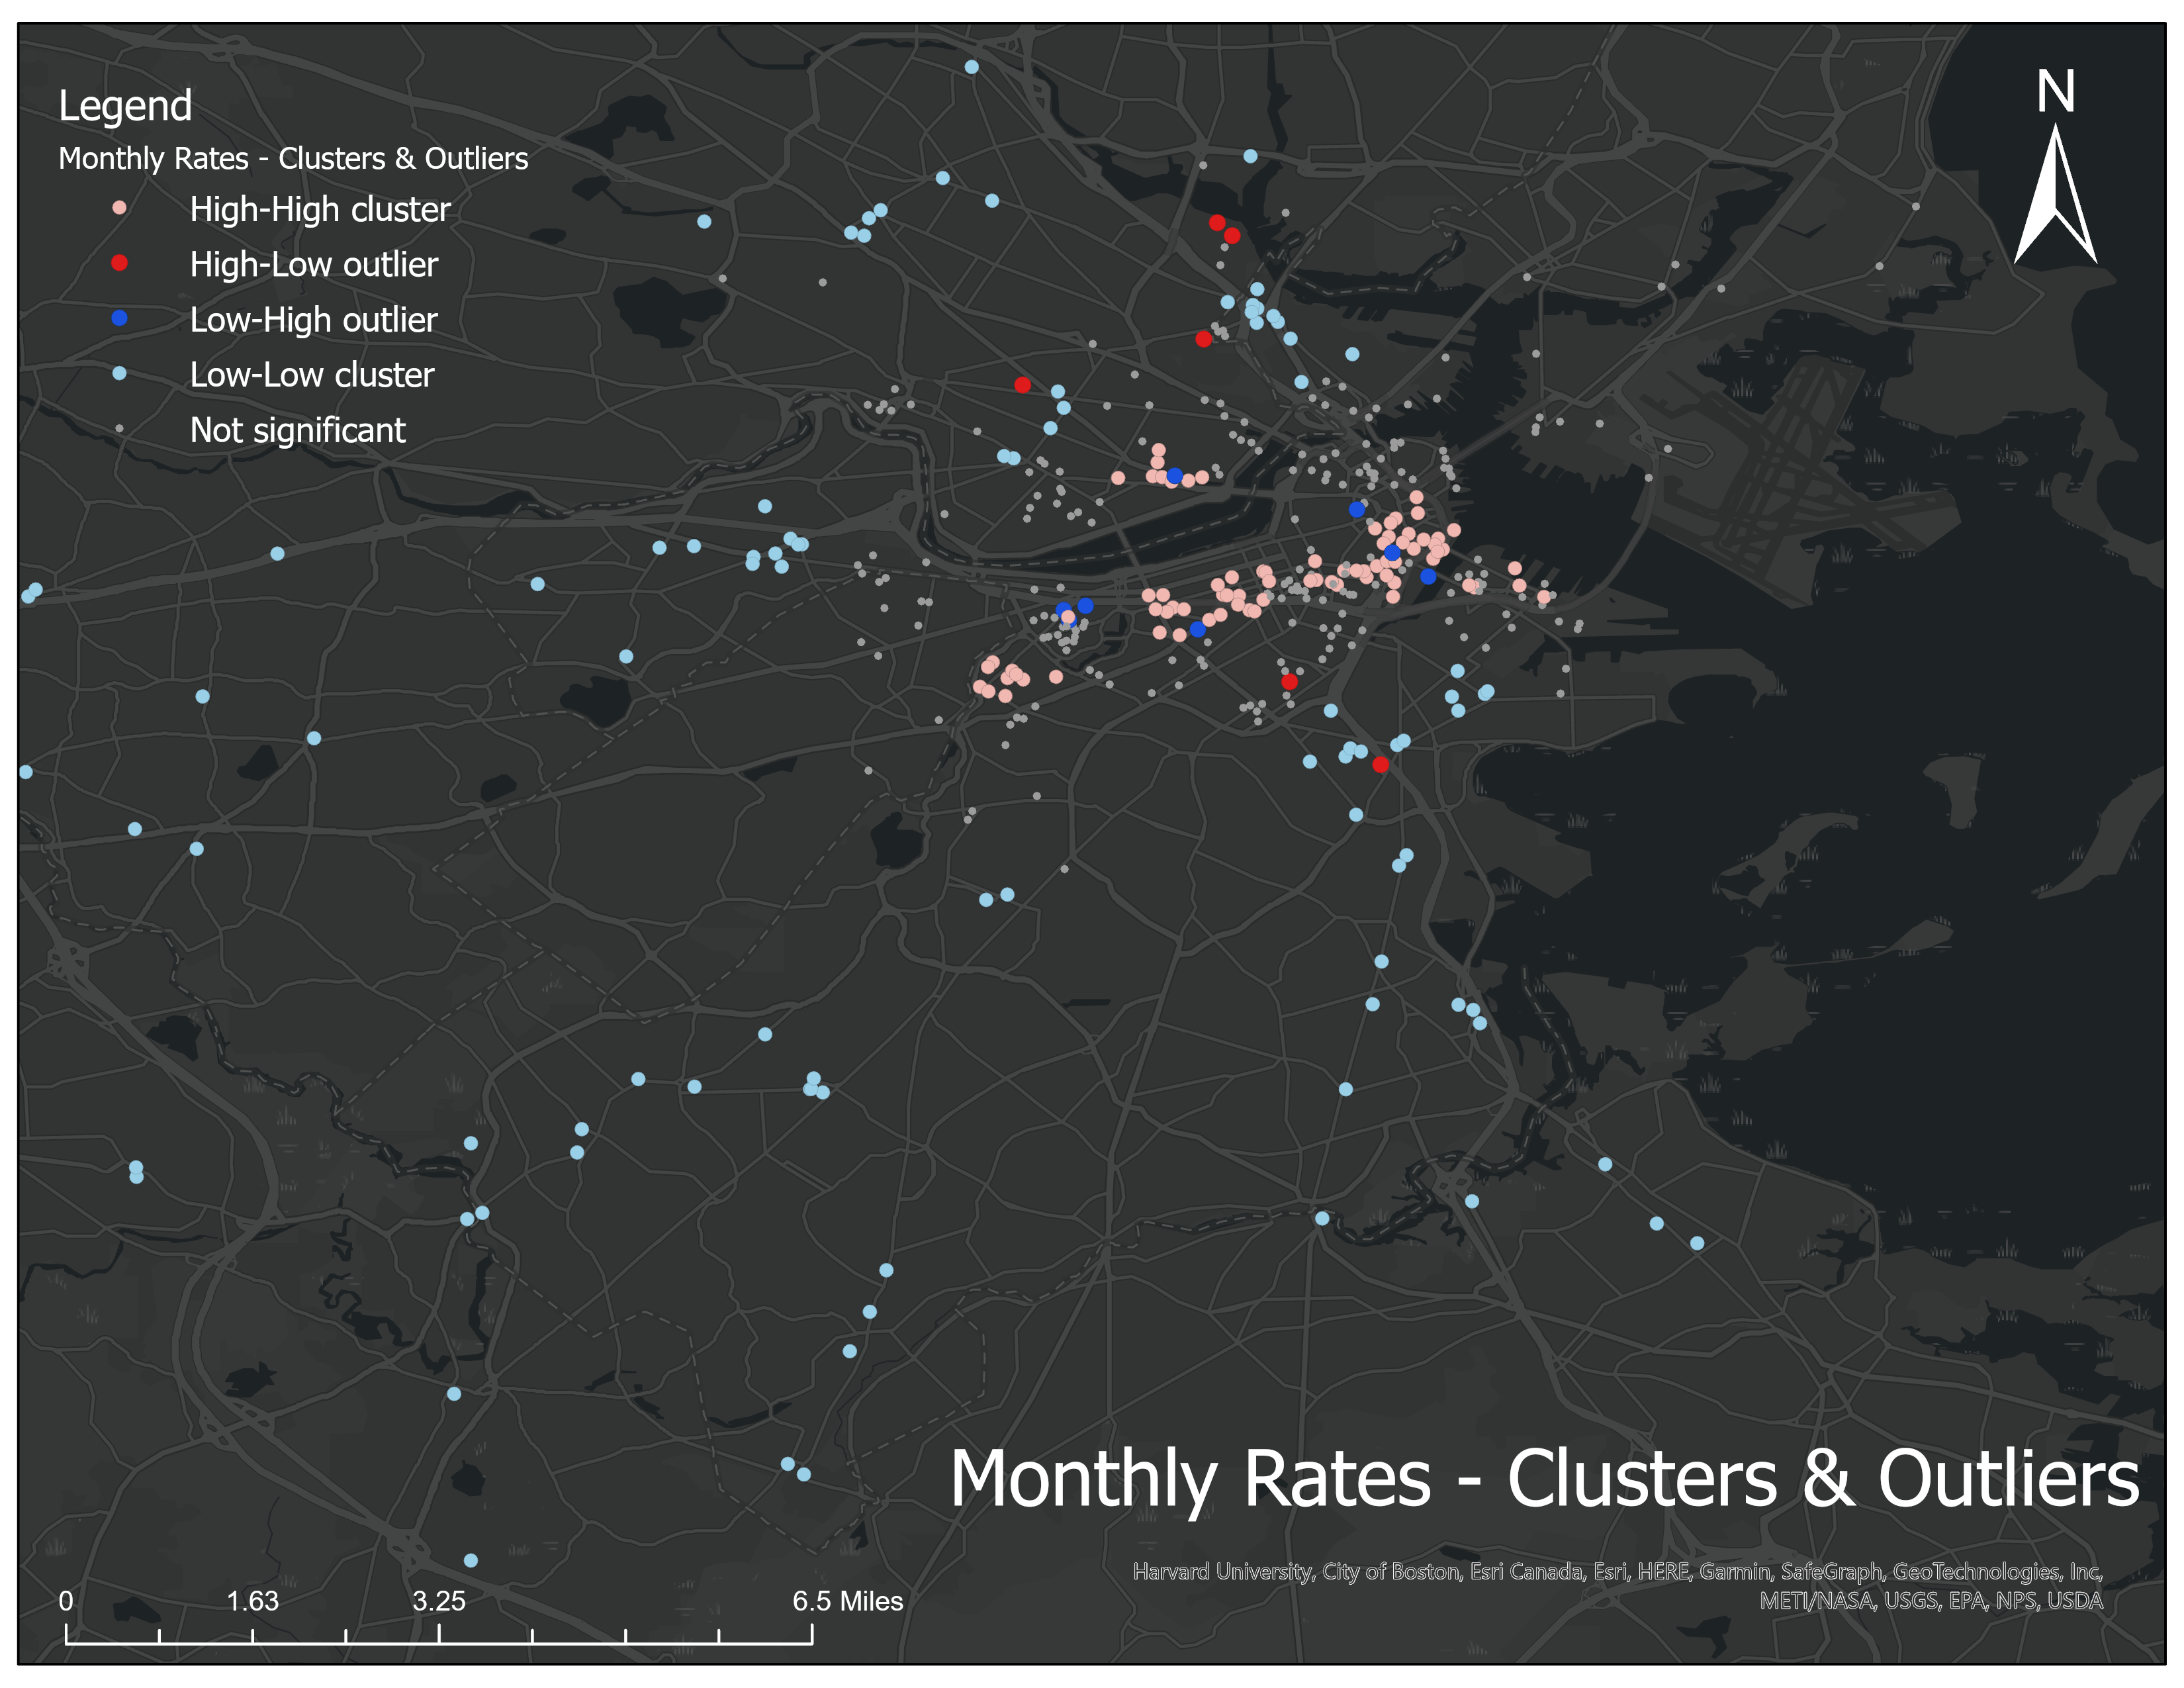

In [ ]:
# IMPORT THE RESULTS OF LOCAL MORAN's I
estmonthLM = gpd.read_file("J:\Shared drives\TMD_TSA\Data\Parking\WebScraped_ParkingCost\\required_inputs\estmonth_April14_HR_DR_MR_LM.geojson")
estmonth = estmonth.to_crs(estmonthLM.crs)
estmonth = estmonth.drop(columns=["index_right"])
estmonth = estmonth.sjoin_nearest(estmonthLM[["COType_HR","COType_DR","COType_MR","geometry"]], how="left")

In [ ]:
# 1 and 13 are very close to each other (see index_right) removing them so can filter later
estmonth = estmonth[~estmonth.index.duplicated(keep='first')]
estmonth

In [ ]:
estmonth.columns

# Aggregate Rates to TAZs



In [ ]:
# get euclidean distance matrix from TAZ centroids to lots
# also reproject to Mass State Plane (meters) so that distance is correct
rdg83 = alltazs.to_crs("EPSG:26986").set_index("id") # TAZ ids are now the column names
estmonth83 = estmonth.to_crs("EPSG:26986") # index is the row name

eucdist = estmonth83.centroid.geometry.apply(lambda g: rdg83.distance(g))
eucdist

In [ ]:
# convert to miles
eucdistmi = eucdist/1609.34
eucdistmi

In [ ]:
# get just closest 16 lots to each TAZ centroid based on euclidean distance
numlot = len(eucdistmi)
for col in eucdistmi.columns:
    big8 = max(eucdistmi[col].nsmallest(16))
    eucdistmi.loc[eucdistmi[col] > big8, col]= np.nan

eucdistmi

In [ ]:
# set distances (weights) to 1 so all have equal weights
eucdistmi[eucdistmi.notna()] = 1
eucdistmi

In [ ]:
tazids = alltazs[(alltazs['town'].isin(["BOSTON","CAMBRIDGE","SOMERVILLE",
                                        "BROOKLINE","NEWTON"])) & (alltazs['id'] < 200000)]["id"].tolist()

In [ ]:
# drop weird column so don't get odd index
estmonth = estmonth.drop('index', axis=1)

In [ ]:
# get lot ids where HL or LH for each time period and exclude them from the weighted average
hr_in = estmonth[~estmonth['COType_HR'].isin(["LH", "HL"])].reset_index()['index']
mr_in = estmonth[~estmonth['COType_MR'].isin(["LH", "HL"])].reset_index()['index']
dr_in = estmonth[~estmonth['COType_DR'].isin(["LH", "HL"])].reset_index()['index']

In [ ]:
# calculate weighted average

# 1. multiply weights (1) by rates
# filter the rates by whether the lot is an outlier - so will match weights below
hr = estmonth["Hourly_Rate_wEst2"].filter(items = hr_in, axis=0)
dr = estmonth["Daily_Rate_wEst2"].filter(items = dr_in, axis=0)
mr = estmonth["Monthly_Rate_wEst2"].filter(items = mr_in, axis=0)

# filter the weights by whether the lot is an outlier, then multiply by rates
xWhr = eucdistmi.filter(items = hr_in, axis=0).multiply(hr, axis="index")
xWdr = eucdistmi.filter(items = dr_in, axis=0).multiply(dr, axis="index")
xWmr = eucdistmi.filter(items = mr_in, axis=0).multiply(mr, axis="index")

# sum weighted rates by TAZ
xW_hr_taz = xWhr.sum()
xW_dr_taz = xWdr.sum()
xW_mr_taz = xWmr.sum()
xW_hr_taz.name = "HRSum16"
xW_dr_taz.name = "DRSum16"
xW_mr_taz.name = "MRSum16"

#sum weights by TAZ
W_taz = eucdistmi.sum()
W_taz.name = "TotalNN"

# join weighted rates sums by taz and sum weights by taz together
wAvg = pd.merge(W_taz,xW_hr_taz, left_index=True, right_index=True)
wAvg = pd.merge(wAvg,xW_dr_taz, left_index=True, right_index=True)
wAvg = pd.merge(wAvg,xW_mr_taz, left_index=True, right_index=True)

# set weighted average rates to 0 where TAZ not in prediction area
wAvg["HRSum16"] = np.where(~wAvg.index.isin(tazids), 0, wAvg["HRSum16"])
wAvg["DRSum16"] = np.where(~wAvg.index.isin(tazids), 0, wAvg["DRSum16"])
wAvg["MRSum16"] = np.where(~wAvg.index.isin(tazids), 0, wAvg["MRSum16"])

wAvg

In [ ]:
estmonth

In [ ]:
estmonth["Monthly_Rate_wEst2"].filter(items = mr_in, axis=0)

In [ ]:
wAvg["NN_Average_HR"] = wAvg["HRSum16"]/wAvg["TotalNN"]
wAvg["NN_Average_DR"] = wAvg["DRSum16"]/wAvg["TotalNN"]
wAvg["NN_Average_MR"] = wAvg["MRSum16"]/wAvg["TotalNN"]

In [ ]:
tazs_avg_rates = pd.merge(rdg83,wAvg, left_index=True, right_index=True)
tazs_avg_rates

## Map to See Nearest Neighbor Average Rates per TAZ

In [ ]:
def agg_maps_est4(hr, cmp_hr, dr, cmp_dr, mr, cmp_mr):
    rplt0 = tazs_avg_rates.dropna(subset=[mr]).explore(column = mr,
                              legend=True,name=mr,
                              tiles="CartoDB positron",
                              cmap=cmp_mr,
                              style_kwds = dict(fillOpacity=1,opacity=1,color="grey"))
    tazs_avg_rates.dropna(subset=[dr]).explore(m=rplt0, column=dr,
                         name=dr,
                         cmap=cmp_dr,
                         style_kwds = dict(fillOpacity=1,opacity=1,color="grey"))
    tazs_avg_rates.dropna(subset=[hr]).explore(m=rplt0, column=hr,
                         name=hr,
                         cmap=cmp_hr,
                         style_kwds = dict(fillOpacity=1,opacity=1,color="grey"))
    folium.LayerControl().add_to(rplt0) # add layer control
    return rplt0

In [ ]:
#MAP MAX TAZ
cmp_mrf = cm.linear.Paired_03.to_step(5).scale(
    tazs_avg_rates.NN_Average_MR.min(),
    tazs_avg_rates.NN_Average_MR.max())
cmp_drf = cm.linear.OrRd_09.to_step(5).scale(
    tazs_avg_rates.NN_Average_DR.min(),
    tazs_avg_rates.NN_Average_DR.max())
cmp_hrf = cm.linear.RdPu_05.to_step(5).scale(
    tazs_avg_rates.NN_Average_HR.min(),
    tazs_avg_rates.NN_Average_HR.max())

mrplttxf = agg_maps_est4("NN_Average_MR", cmp_mrf, "NN_Average_DR", cmp_drf,"NN_Average_HR", cmp_hrf)
mrplttxf

In [ ]:
tazs_avg_rates["NN_Average_MR_2010"] = tazs_avg_rates["NN_Average_MR"] * 0.69 # convert to 2010 dollars
tazs_avg_rates["NN_Average_DR_2010"] = tazs_avg_rates["NN_Average_DR"] * 0.69 # convert to 2010 dollars
tazs_avg_rates["NN_Average_HR_2010"] = tazs_avg_rates["NN_Average_HR"] * 0.69 # convert to 2010 dollars

# Exports
(For presentation)

In [ ]:
tazs_avg_rates.drop("geometry",axis=1).to_csv("J:\\Shared drives\\TMD_TSA\\Data\\Parking\\WebScraped_ParkingCost\\tazs_avg_rates2010_Apr25c.csv")

In [ ]:
tazs_avg_rates.to_file("J:\Shared drives\\TMD_TSA\Data\Parking\WebScraped_ParkingCost\\tazs_avg_ratesApr25c.geojson")  

In [ ]:
fred.equals(george)

In [ ]:
np.array_equiv(fred, george)

In [ ]:
george['4398'].equals(fred['4398'])

In [ ]:
george.round(5).equals(fred.round(5))

In [ ]:
elots = pd.read_csv("J:\\Shared drives\\TMD_TSA\\Data\\Parking\\WebScraped_ParkingCost\\estmonth_April26a.csv")
estmonth = pd.read_csv("J:\\Shared drives\\TMD_TSA\\Data\\Parking\\WebScraped_ParkingCost\\estmonth.csv")

In [ ]:
estmonth[["Monthly_Rate_wEst2","Daily_Rate_wEst2","Hourly_Rate_wEst2"]]

In [ ]:
elots[["USER_lot_url","MR_wEst2","DR_wEst2","HR_wEst2"]].sort_values(by="USER_lot_url").equals(estmonth[["USER_lot_url","Monthly_Rate_wEst2","Daily_Rate_wEst2","Hourly_Rate_wEst2"]].sort_values(by="USER_lot_url"))

In [ ]:
elots["USER_lot_url"].sort_values().equals(estmonth["USER_lot_url"].sort_values())

In [ ]:
elots[["USER_lot_url","HR_wEst2"]].sort_values(by="USER_lot_url").equals(estmonth[["USER_lot_url","Hourly_Rate_wEst2"]].sort_values(by="USER_lot_url"))

In [ ]:
elots[["USER_lot_url","HR_wEst2"]].sort_values(by="USER_lot_url")

In [ ]:
estmonth[["USER_lot_url","Hourly_Rate_wEst2"]].sort_values(by="USER_lot_url")